In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7.7)
plt.rcParams['font.size'] = 11

# Configuration
CONFIG = {
    'ticker': '^GSPC',
    'start_date': '2000-01-01',
    'lookforward_window': 20,
    'test_size': 100,
    'lag_features': [1, 20],
    'random_seed': 5678
}

np.random.seed(CONFIG['random_seed'])

def download_stock_data(ticker: str, start_date: str) -> pd.DataFrame:
    try:
        print(f"Downloading data for {ticker}...")
        stock = yf.Ticker(ticker)
        hist = stock.history(period="max")
        
        if hist.empty:
            raise ValueError(f"No data retrieved for {ticker}")
        
        df = hist[hist.index >= start_date].copy()
        print(f"Downloaded {len(df)} records from {df.index.min().date()} to {df.index.max().date()}")
        
        return df
    
    except Exception as e:
        print(f"Error downloading data: {str(e)}")
        raise


def calculate_forward_max_return(df: pd.DataFrame, 
                                  price_col: str = 'Close', 
                                  window: int = 20) -> pd.DataFrame:
    df = df.copy()
    
    # Fixed: Correct forward-looking calculation using list comprehension
    future_max = []
    for i in range(len(df)):
        if i + window >= len(df):
            future_max.append(np.nan)
        else:
            future_max.append(df[price_col].iloc[i+1:i+window+1].max())
    
    df['future_max'] = future_max
    df['target'] = 100 * (df['future_max'] - df[price_col]) / df[price_col]
    
    df = df.dropna(subset=['target'])
    
    print(f"Calculated forward {window}-day max return")
    print(f"Target stats: mean={df['target'].mean():.2f}%, std={df['target'].std():.2f}%")
    print(f"Range: [{df['target'].min():.2f}%, {df['target'].max():.2f}%]")
    
    return df


def create_lagged_features(df: pd.DataFrame, 
                           target_col: str = 'target', 
                           lags: list = [1, 20]) -> pd.DataFrame:
    df = df.copy()
    
    for lag in lags:
        df[f'lag{lag}'] = df[target_col].shift(lag)
    
    df = df.dropna()
    print(f"Created lagged features: {[f'lag{l}' for l in lags]}")
    print(f"Final dataset size: {len(df)} observations")
    
    return df


def split_train_test(df: pd.DataFrame, test_size: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_df = df.iloc[:-test_size].copy()
    test_df = df.iloc[-test_size:].copy()
    
    print(f"Data Split:")
    print(f"Training: {len(train_df)} samples ({train_df.index.min().date()} to {train_df.index.max().date()})")
    print(f"Testing: {len(test_df)} samples ({test_df.index.min().date()} to {test_df.index.max().date()})")
    
    return train_df, test_df


def fit_markov_models(train_df: pd.DataFrame, 
                      target_col: str = 'target') -> Dict:
    models = {}
    
    print("\n" + "="*70)
    print("FITTING MARKOV SWITCHING MODELS")
    print("="*70)
    
    # Model 1: 2-regime, switching intercept only
    print("\n[1/5] Fitting 2-regime model (switching intercept)...")
    try:
        model_2reg = sm.tsa.MarkovRegression(
            train_df[target_col], 
            k_regimes=2
        )
        result_2reg = model_2reg.fit(disp=False)
        models['2_regime'] = {
            'model': model_2reg,
            'result': result_2reg,
            'description': '2 regimes, switching intercept'
        }
        print(f"AIC: {result_2reg.aic:.2f}, BIC: {result_2reg.bic:.2f}")
    except Exception as e:
        print(f"Failed: {str(e)}")
    
    # Model 2: 5-regime, switching intercept only
    print("\n[2/5] Fitting 5-regime model (switching intercept)...")
    try:
        model_5reg = sm.tsa.MarkovRegression(
            train_df[target_col], 
            k_regimes=5
        )
        result_5reg = model_5reg.fit(disp=False)
        models['5_regime'] = {
            'model': model_5reg,
            'result': result_5reg,
            'description': '5 regimes, switching intercept'
        }
        print(f"AIC: {result_5reg.aic:.2f}, BIC: {result_5reg.bic:.2f}")
    except Exception as e:
        print(f"Failed: {str(e)}")
    
    # Model 3: 3-regime with lag1 and lag20 exogenous variables
    print("\n[3/5] Fitting 3-regime model with lag features...")
    try:
        model_3reg_exog = sm.tsa.MarkovRegression(
            train_df[target_col], 
            k_regimes=3,
            exog=train_df[['lag1', 'lag20']]
        )
        result_3reg_exog = model_3reg_exog.fit(disp=False)
        models['3_regime_exog'] = {
            'model': model_3reg_exog,
            'result': result_3reg_exog,
            'description': '3 regimes, switching intercept & exog (lag1, lag20)'
        }
        print(f"AIC: {result_3reg_exog.aic:.2f}, BIC: {result_3reg_exog.bic:.2f}")
    except Exception as e:
        print(f"Failed: {str(e)}")
    
    # Model 4: 3-regime with lag20 and switching variance
    print("\n[4/5] Fitting 3-regime model with switching variance...")
    try:
        model_3reg_var = sm.tsa.MarkovRegression(
            train_df[target_col], 
            k_regimes=3,
            trend='c',
            switching_variance=True,
            exog=train_df[['lag20']]
        )
        result_3reg_var = model_3reg_var.fit(search_reps=50, method='bfgs', disp=False)
        models['3_regime_var'] = {
            'model': model_3reg_var,
            'result': result_3reg_var,
            'description': '3 regimes, switching variance, lag20'
        }
        print(f"AIC: {result_3reg_var.aic:.2f}, BIC: {result_3reg_var.bic:.2f}")
    except Exception as e:
        print(f"Failed: {str(e)}")
    
    # Model 5: Best model with both lags and switching variance
    print("\n[5/5] Fitting comprehensive 3-regime model...")
    try:
        model_best = sm.tsa.MarkovRegression(
            train_df[target_col], 
            k_regimes=3,
            trend='c',
            switching_variance=True,
            exog=train_df[['lag1', 'lag20']]
        )
        result_best = model_best.fit(search_reps=50, method='bfgs', disp=False)
        models['3_regime_full'] = {
            'model': model_best,
            'result': result_best,
            'description': '3 regimes, switching variance, lag1 & lag20'
        }
        print(f"AIC: {result_best.aic:.2f}, BIC: {result_best.bic:.2f}")
    except Exception as e:
        print(f"Failed: {str(e)}")
    
    return models


def compare_models(models: Dict) -> pd.DataFrame:
    comparison_data = []
    
    for name, model_dict in models.items():
        result = model_dict['result']
        comparison_data.append({
            'Model': name,
            'Description': model_dict['description'],
            'K_Regimes': result.k_regimes,
            'N_Params': len(result.params),
            'Log_Likelihood': result.llf,
            'AIC': result.aic,
            'BIC': result.bic,
            'HQIC': result.hqic if hasattr(result, 'hqic') else np.nan
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('BIC')
    
    print("\n" + "="*70)
    print("MODEL COMPARISON")
    print("="*70)
    print(df_comparison.to_string(index=False))
    print("\nLower AIC/BIC indicates better model fit")
    
    return df_comparison


def analyze_regime_characteristics(result, model_name: str):
    print(f"\n{'='*70}")
    print(f"REGIME ANALYSIS: {model_name}")
    print(f"{'='*70}")
    
    k_regimes = result.k_regimes
    
    print("\nExpected Regime Durations:")
    durations = result.expected_durations
    for i, duration in enumerate(durations):
        print(f"Regime {i}: {duration:.2f} days ({duration/252:.2f} years)")
    
    print("\nRegime Mean Returns:")
    for i in range(k_regimes):
        param_name = f'regime[{i}].const' if f'regime[{i}].const' in result.params.index else f'const'
        if param_name in result.params.index:
            mean_val = result.params[param_name]
            print(f"Regime {i}: {mean_val:.3f}%")
    
    print("\nTransition Probability Matrix:")
    transition_matrix = result.regime_transition.reshape(k_regimes, k_regimes)
    df_trans = pd.DataFrame(
        transition_matrix,
        columns=[f"To_{i}" for i in range(k_regimes)],
        index=[f"From_{i}" for i in range(k_regimes)]
    )
    print(df_trans.round(4).to_string())
    
    if hasattr(result, 'switching_variance') and result.switching_variance:
        print("\nRegime-Specific Variances:")
        for i in range(k_regimes):
            var_param = f'regime[{i}].sigma2'
            if var_param in result.params.index:
                var_val = result.params[var_param]
                print(f"Regime {i}: σ² = {var_val:.4f} (σ = {np.sqrt(var_val):.4f})")


def plot_regime_probabilities(result, target_series: pd.Series, 
                               model_name: str, figsize=(15, 10)):
    k_regimes = result.k_regimes
    probs = result.smoothed_marginal_probabilities
    
    fig, axes = plt.subplots(k_regimes + 1, 1, figsize=figsize, sharex=True)
    
    axes[0].plot(target_series.index, target_series.values, 
                 color='black', linewidth=0.5, alpha=0.7)
    axes[0].set_ylabel('Target (%)', fontsize=10, fontweight='bold')
    axes[0].set_title(f'{model_name}: Target Variable and Regime Probabilities', 
                     fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    
    colors = plt.cm.Set3(np.linspace(0, 1, k_regimes))
    
    for i in range(k_regimes):
        axes[i+1].fill_between(probs.index, 0, probs.iloc[:, i], 
                               alpha=0.6, color=colors[i], label=f'Regime {i}')
        axes[i+1].set_ylabel(f'P(Regime {i})', fontsize=9, fontweight='bold')
        axes[i+1].set_ylim([0, 1])
        axes[i+1].grid(True, alpha=0.3)
        axes[i+1].legend(loc='upper right', fontsize=8)
    
    axes[-1].set_xlabel('Date', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    return fig


def plot_regime_overlay(result, target_series: pd.Series, 
                        model_name: str, figsize=(15, 6)):
    probs = result.smoothed_marginal_probabilities
    regime_classification = probs.idxmax(axis=1)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = plt.cm.Set3(np.linspace(0, 1, result.k_regimes))
    
    for regime_idx in range(result.k_regimes):
        mask = regime_classification == regime_idx
        ax.scatter(target_series.index[mask], target_series.values[mask],
                  c=[colors[regime_idx]], s=10, alpha=0.6, 
                  label=f'Regime {regime_idx}')
    
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('20-Day Forward Max Return (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}: Regime Classification Overlay', 
                fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def analyze_regime_periods(result, df: pd.DataFrame, target_col: str = 'target'):
    probs = result.smoothed_marginal_probabilities
    regime_classification = probs.idxmax(axis=1)
    
    print(f"\n{'='*70}")
    print("REGIME PERIOD STATISTICS")
    print(f"{'='*70}")
    
    for regime_idx in range(result.k_regimes):
        mask = regime_classification == regime_idx
        regime_data = df.loc[mask, target_col]
        
        print(f"\nRegime {regime_idx}:")
        print(f"Frequency: {mask.sum()} days ({100*mask.sum()/len(df):.1f}%)")
        print(f"Mean return: {regime_data.mean():.3f}%")
        print(f"Std dev: {regime_data.std():.3f}%")
        print(f"Min: {regime_data.min():.3f}%")
        print(f"Max: {regime_data.max():.3f}%")
        
        regime_series = (regime_classification == regime_idx).astype(int)
        regime_groups = (regime_series != regime_series.shift()).cumsum()
        longest_period = regime_series.groupby(regime_groups).sum().max()
        print(f"Longest period: {longest_period} consecutive days")


MARKOV SWITCHING DYNAMIC REGRESSION ANALYSIS
Downloaded 6546 records from 2000-01-03 to 2026-01-12
Calculated forward 20-day max return
Target stats: mean=2.92%, std=2.73%
Range: [-5.27%, 28.48%]
Created lagged features: ['lag1', 'lag20']
Final dataset size: 6506 observations
Data Split:
Training: 6406 samples (2000-02-01 to 2025-07-22)
Testing: 100 samples (2025-07-23 to 2025-12-11)

FITTING MARKOV SWITCHING MODELS

[1/5] Fitting 2-regime model (switching intercept)...
AIC: 27673.02, BIC: 27706.85

[2/5] Fitting 5-regime model (switching intercept)...
AIC: 22769.37, BIC: 22945.26

[3/5] Fitting 3-regime model with lag features...
AIC: 20512.60, BIC: 20620.84

[4/5] Fitting 3-regime model with switching variance...
AIC: 23573.55, BIC: 23675.02

[5/5] Fitting comprehensive 3-regime model...
AIC: 18311.89, BIC: 18433.66

MODEL COMPARISON
        Model                                         Description  K_Regimes  N_Params  Log_Likelihood          AIC          BIC         HQIC
3_regime_

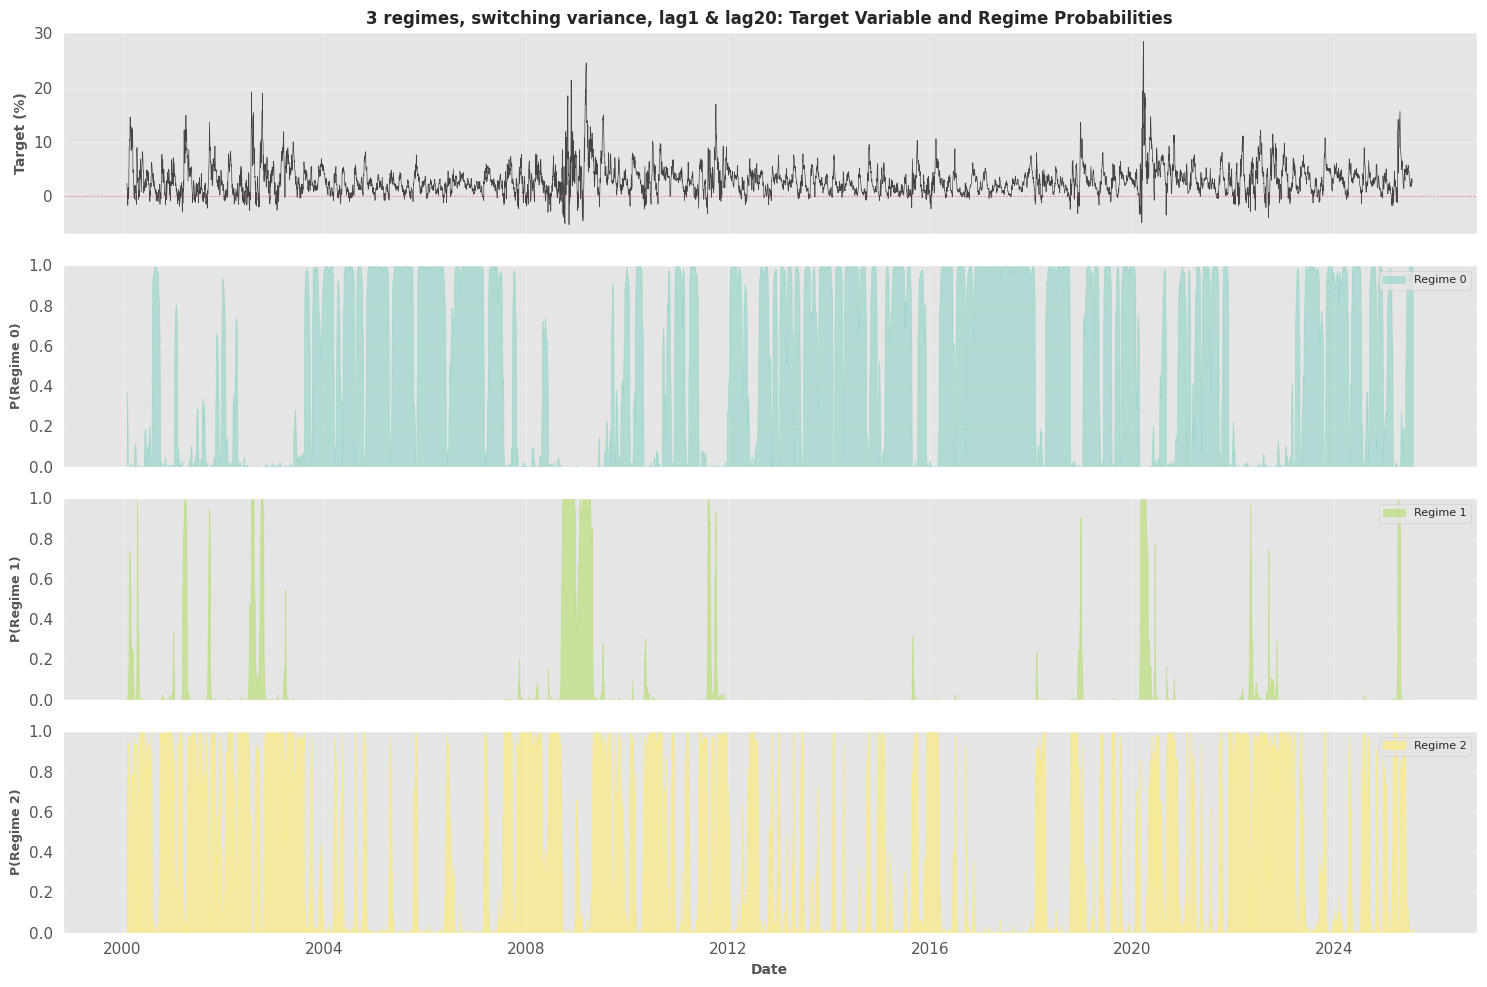

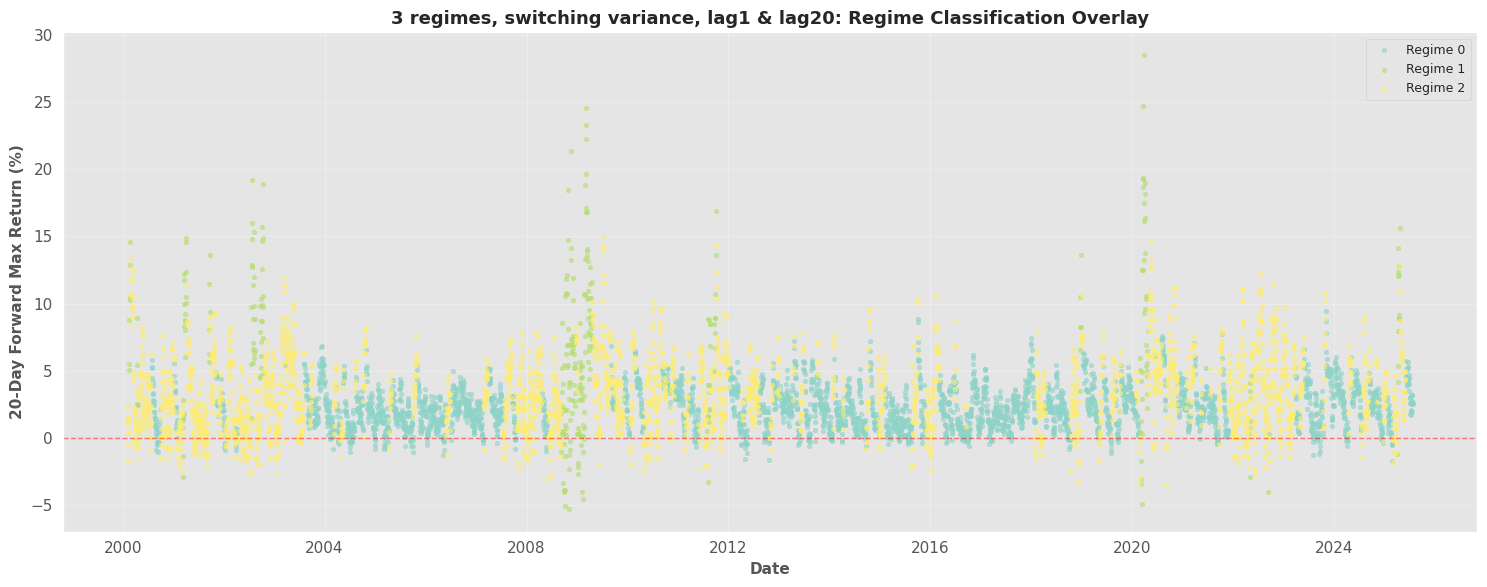

In [2]:

print("\n" + "="*70)
print("MARKOV SWITCHING DYNAMIC REGRESSION ANALYSIS")
print("="*70)

df = download_stock_data(CONFIG['ticker'], CONFIG['start_date'])

df = calculate_forward_max_return(
    df, 
    price_col='Close', 
    window=CONFIG['lookforward_window']
)

df = create_lagged_features(df, lags=CONFIG['lag_features'])

train_df, test_df = split_train_test(df, CONFIG['test_size'])

models = fit_markov_models(train_df)

comparison_df = compare_models(models)

best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*70}")
print(best_model['result'].summary())

analyze_regime_characteristics(best_model['result'], best_model['description'])
analyze_regime_periods(best_model['result'], train_df)

print("\nGenerating visualizations...")

fig1 = plot_regime_probabilities(
    best_model['result'], 
    train_df['target'],
    best_model['description']
)
plt.savefig('markov_regime_probabilities.png', dpi=300, bbox_inches='tight')
print("Saved: markov_regime_probabilities.png")

fig2 = plot_regime_overlay(
    best_model['result'],
    train_df['target'],
    best_model['description']
)
plt.savefig('markov_regime_overlay.png', dpi=300, bbox_inches='tight')
print("Saved: markov_regime_overlay.png")

plt.show()

